In [56]:
import sys
sys.path.append('../src')

from dnadb import dna, fastq, sample
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.manifold import TSNE
import tensorflow as tf
from tqdm.auto import tqdm
from typing import Optional
import wandb

from deepdna.data import metrics
from deepdna.nn.data_generators import SampleValuePairGenerator, SequenceGenerator
from deepdna.nn.losses import SortedLoss, ContrastiveLoss
from deepdna.nn.metrics import contrastive_accuracy
from deepdna.nn.models import load_model, clip, contrastive, dnabert, setbert

## DataSequenceGenerator

In [2]:
samples = []
for path in Path("/home/dwl2x/work/Datasets/hopland").iterdir():
    samples.append(sample.load_fastq(
        path,
        path.name.split('-16S')[0].replace('-', '.')
    ))
len(samples)

128

In [3]:
label_data = pd.read_csv("/home/shared/hopland/CKI_metabolites_Hilic_pos_neg_merged_machine_learning.csv")
label_data

,Unique_sample_ID,treatment,replicate,X4_NEG,X5_NEG,X10_NEG,X13_NEG,X14_NEG,X18_NEG,X19_NEG,...,X66530_POS,X66541_POS,X66587_POS,X66598_POS,X66614_POS,X66675_POS,X67011_POS,X67172_POS,X67280_POS,X67355_POS
0,Ur1.B,Bulk-100W-U0-Mar,A,243000000.0,235000000.0,23400000.0,57500000.0,65000000.0,5562637.5,34300000.0,...,83507.53906,8031.719727,57523.46094,65193.13281,0.000000,0.00000,14128.66309,0.00000,14964.21973,0.000000
1,Ur1.R,Rhizo-100W-U0-Mar,A,132000000.0,129000000.0,14200000.0,53600000.0,67600000.0,6555448.5,36300000.0,...,206667.57810,28761.597660,58682.88672,40952.87891,0.000000,0.00000,18445.79297,0.00000,0.00000,10654.476560
2,Ur10.B,Bulk-050W-U0-Mar,B,209000000.0,205000000.0,23100000.0,59500000.0,55900000.0,4960913.5,36100000.0,...,42598.76953,0.000000,89925.29688,0.00000,36869.980470,0.00000,20201.39063,0.00000,16639.10156,0.000000
3,Ur10.R,Rhizo-050W-U0-Mar,B,169000000.0,165000000.0,27000000.0,42100000.0,50500000.0,10200000.0,28600000.0,...,142107.01560,95066.093750,202008.34380,81447.16406,376262.312500,44532.87891,47982.80078,21767.06445,30508.04883,6302.954590
4,Ur11.B,Bulk-050W-U0-Mar,C,279000000.0,271000000.0,30100000.0,61900000.0,64300000.0,8659287.0,41300000.0,...,92879.04688,24184.380860,92277.72656,42621.26953,25223.707030,0.00000,0.00000,0.00000,18528.18555,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Ur7.R,Rhizo-100W-U2-Mar,C,233000000.0,225000000.0,14700000.0,49800000.0,53100000.0,13400000.0,40600000.0,...,354714.78130,226208.515600,118754.62500,54298.57813,49076.597660,16845.92578,35719.20703,25592.41406,19310.12891,37263.636720
124,Ur8.B,Bulk-100W-U2-Mar,D,271000000.0,262000000.0,19700000.0,65400000.0,66600000.0,7662917.0,43700000.0,...,78684.25000,22637.021480,57935.89453,25321.66797,0.000000,0.00000,0.00000,0.00000,27208.94531,0.000000
125,Ur8.R,Rhizo-100W-U2-Mar,D,181000000.0,176000000.0,14000000.0,52400000.0,47200000.0,10500000.0,37900000.0,...,244147.34380,129768.546900,132295.81250,80746.15625,97399.296880,17996.95898,19044.96094,14133.46289,0.00000,11698.916020
126,Ur9.B,Bulk-050W-U0-Mar,A,273000000.0,268000000.0,19000000.0,62400000.0,69600000.0,4402610.5,37800000.0,...,71842.89063,10209.375000,71277.13281,31502.70898,0.000000,0.00000,23727.10547,0.00000,10649.65625,0.000000


In [4]:
keys = label_data["Unique_sample_ID"].to_numpy()
values = label_data.drop(["Unique_sample_ID", "treatment", "replicate"], axis=1).to_numpy()
len(keys), len(values)

(128, 128)

In [5]:
values = values / np.max(values, axis=0)

In [6]:
labels = dict(zip(keys, values))
labels["Ur1.B"]

array([0.62953368, 0.62334218, 0.24528302, ..., 0.        , 0.07612066,
       0.        ])

In [7]:
for s in samples:
    assert s.name in labels

## Data Generator

In [8]:
train_data = SampleValuePairGenerator(
    samples,
    labels,
    sequence_length=150,
    kmer=3,
    subsample_size=1000,
    batch_size=16,
    batches_per_epoch=100,
    rng=np.random.default_rng(0))

val_data = SampleValuePairGenerator(
    samples,
    labels,
    sequence_length=150,
    kmer=3,
    subsample_size=1000,
    batch_size=16,
    shuffle=False,
    batches_per_epoch=16,
    rng=np.random.default_rng(1))

In [9]:
train_data[0][0]

(array([[[49,  6, 26, ..., 23, 28, 50],
         [ 6, 27, 44, ..., 17,  6, 27],
         [ 6, 27, 44, ..., 17,  6, 27],
         ...,
         [17,  6, 27, ..., 23, 30, 58],
         [ 6, 26, 40, ..., 45, 52, 19],
         [ 6, 27, 44, ..., 30, 58, 43]],
 
        [[ 6, 27, 44, ..., 26, 42, 42],
         [49,  6, 26, ..., 21, 22, 26],
         [ 4, 19, 14, ..., 17,  6, 27],
         ...,
         [ 6, 27, 44, ..., 20, 18, 11],
         [49,  4, 18, ..., 49,  6, 26],
         [ 6, 27, 44, ..., 17,  6, 27]],
 
        [[ 6, 27, 44, ..., 17,  6, 27],
         [49,  6, 27, ..., 20, 17,  6],
         [33,  6, 27, ..., 23, 30, 58],
         ...,
         [49,  6, 27, ..., 21, 22, 26],
         [49,  6, 27, ..., 20, 17,  6],
         [ 4, 18,  8, ...,  6, 26, 43]],
 
        ...,
 
        [[51, 14, 58, ...,  2,  8, 35],
         [49,  6, 27, ..., 23, 30, 58],
         [49,  6, 27, ..., 23, 30, 58],
         ...,
         [ 6, 26, 40, ..., 45, 52, 19],
         [ 6, 27, 44, ..., 30, 58, 43],


In [10]:
api = wandb.Api()

In [11]:
run = wandb.init(project="clip-setbert-hopland", name="dual-loss-mse")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sirdavidludwig. Use `wandb login --relogin` to force relogin


In [12]:
path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:v3").download()
# path = run.use_artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:v3").download()
dnabert_encoder = dnabert.DnaBertEncoderModel(
    load_model(path, dnabert.DnaBertPretrainModel).base,
    chunk_size=256
)

wandb:   4 of 4 files downloaded.  
2023-06-09 12:57:24.090853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 12:57:24.091196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 12:57:24.097559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 12:57:24.097795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 12:57:24.097974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:9

In [13]:
# path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-hopl-64:latest").download()
path = Path("~/.cache/wandb/wandb/run-20230502_161947-83qte62b/files/model").expanduser()
pretrained_model = tf.keras.models.load_model(path, custom_objects={"SortedLoss": SortedLoss})
pretrained_model

In [14]:
setbert_model = setbert.SetBertModel(
    dnabert_encoder,
    embed_dim=64,
    max_set_len=1000,
    stack=8,
    num_heads=8)
    # num_induce=128)
setbert_model.layers[1].set_weights(pretrained_model.base.model.get_weights())

In [15]:
setbert_encoder = setbert.SetBertEncoderModel(setbert_model)

In [16]:
label_data.shape[1]

11482

In [17]:
y = x = tf.keras.layers.Input((label_data.shape[1] - 3))

# 512 block
y = r = tf.keras.layers.Dense(512)(y)
y = tf.keras.layers.LayerNormalization()(y)
y = tf.keras.layers.Activation("gelu")(y)
y = tf.keras.layers.Dropout(0.10)(y)
y = tf.keras.layers.Add()((y, r))

# 128 block
y = r = tf.keras.layers.Dense(128)(y)
y = tf.keras.layers.LayerNormalization()(y)
y = tf.keras.layers.Activation("gelu")(y)
y = tf.keras.layers.Dropout(0.10)(y)
y = tf.keras.layers.Add()((y, r))

# 64 block
y = r = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.LayerNormalization()(y)
y = tf.keras.layers.Activation("gelu")(y)
y = tf.keras.layers.Dropout(0.10)(y)
y = tf.keras.layers.Add()((y, r))

abundance_encoder = tf.keras.Model(x, y)
abundance_encoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 11479)]      0           []                               
                                                                                                  
 dense_33 (Dense)               (None, 512)          5877760     ['input_6[0][0]']                
                                                                                                  
 layer_normalization_16 (LayerN  (None, 512)         1024        ['dense_33[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation (Activation)        (None, 512)          0           ['layer_normalization_16[0]

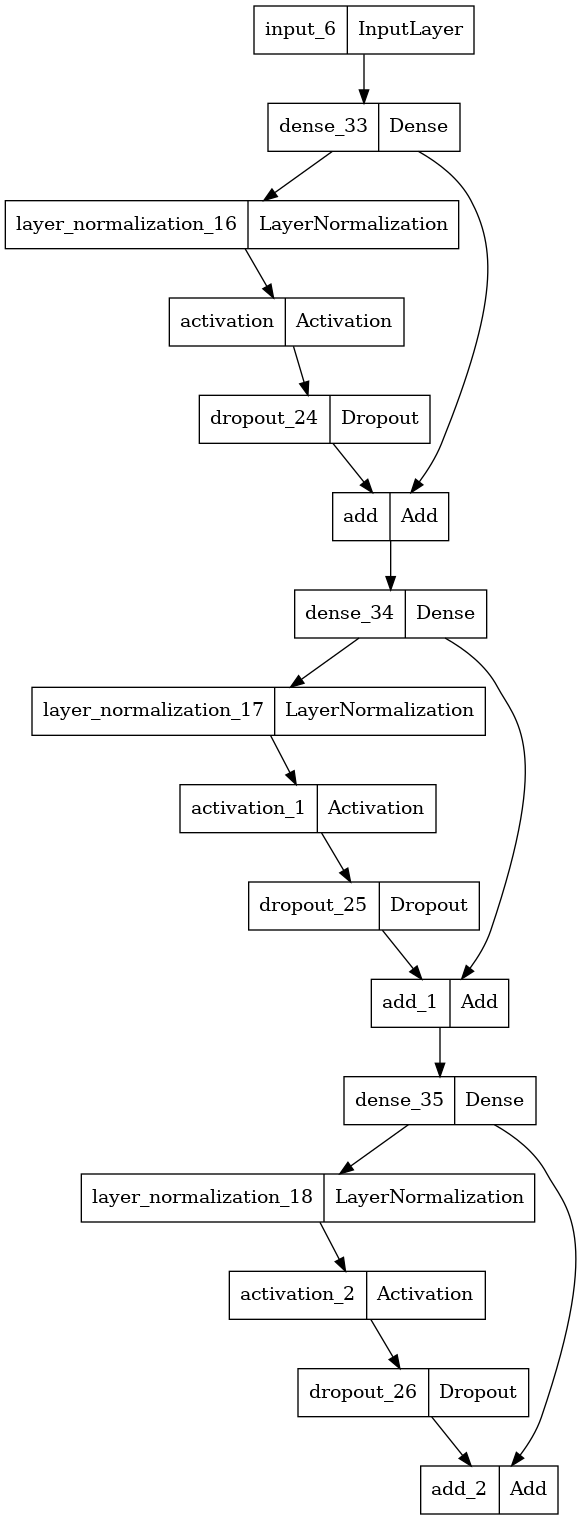

In [18]:
tf.keras.utils.plot_model(abundance_encoder, to_file="/tmp/model.png")

1/1 [==============================] - 1s 767ms/step


2023-06-09 12:57:37.032143: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-09 12:57:37.137783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1/1 [==============================] - 7s 7s/step


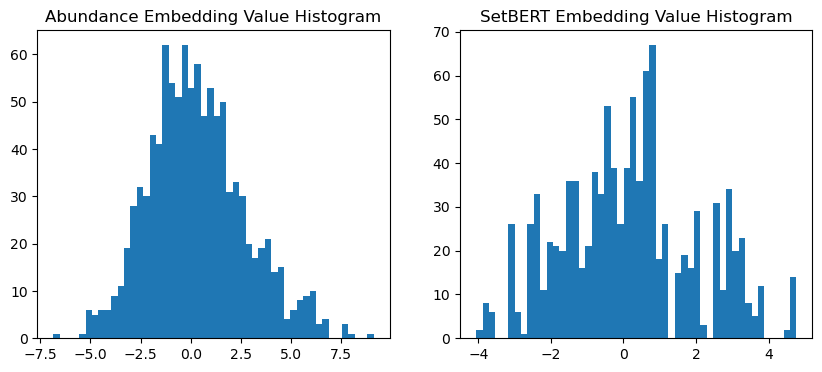

In [18]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Abundance Embedding Value Histogram")
plt.hist(abundance_encoder.predict(val_data[0][0][1]).flatten(), bins=50)

plt.subplot(1, 2, 2)
plt.title("SetBERT Embedding Value Histogram")
plt.hist(setbert_encoder.predict(val_data[0][0][0]).flatten(), bins=50)
plt.show()

In [19]:
model = contrastive.ClipModel(
    setbert_encoder,
    abundance_encoder,
    embed_dim=64,
    activation=None,
    use_shared_projections=True,
    shared_latent_space=True
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=[
        ContrastiveLoss(),
        tf.keras.losses.MeanAbsoluteError()
    ]
)

In [20]:
callbacks = []

wandb_callback = wandb.keras.WandbCallback(save_model=False)
wandb_callback.save_model_as_artifact = False
callbacks.append(wandb_callback)

callbacks.append(
    tf.keras.callbacks.ModelCheckpoint("./hopland-clip-pretrained-dual-loss-mse")
)

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=100, initial_epoch=0, callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 3.5047 - output_1_loss: 2.7726 - output_2_loss: 0.7321 - contrastive_accuracy: 0.0756

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 628s 6s/step - loss: 3.5047 - output_1_loss: 2.7726 - output_2_loss: 0.7321 - contrastive_accuracy: 0.0756 - val_loss: 3.0490 - val_output_1_loss: 2.7719 - val_output_2_loss: 0.2771 - val_contrastive_accuracy: 0.1055
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 3.2402 - output_1_loss: 2.7721 - output_2_loss: 0.4681 - contrastive_accuracy: 0.0787

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 3.2402 - output_1_loss: 2.7721 - output_2_loss: 0.4681 - contrastive_accuracy: 0.0787 - val_loss: 3.0523 - val_output_1_loss: 2.7717 - val_output_2_loss: 0.2805 - val_contrastive_accuracy: 0.0879
Epoch 3/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 3.1834 - output_1_loss: 2.7719 - output_2_loss: 0.4115 - contrastive_accuracy: 0.0919

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 3.1834 - output_1_loss: 2.7719 - output_2_loss: 0.4115 - contrastive_accuracy: 0.0919 - val_loss: 3.0255 - val_output_1_loss: 2.7711 - val_output_2_loss: 0.2543 - val_contrastive_accuracy: 0.1348
Epoch 4/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 3.1473 - output_1_loss: 2.7712 - output_2_loss: 0.3760 - contrastive_accuracy: 0.1084

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 3.1473 - output_1_loss: 2.7712 - output_2_loss: 0.3760 - contrastive_accuracy: 0.1084 - val_loss: 3.0438 - val_output_1_loss: 2.7701 - val_output_2_loss: 0.2737 - val_contrastive_accuracy: 0.1211
Epoch 5/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 3.1212 - output_1_loss: 2.7700 - output_2_loss: 0.3512 - contrastive_accuracy: 0.1228

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 3.1212 - output_1_loss: 2.7700 - output_2_loss: 0.3512 - contrastive_accuracy: 0.1228 - val_loss: 3.0269 - val_output_1_loss: 2.7679 - val_output_2_loss: 0.2590 - val_contrastive_accuracy: 0.1484
Epoch 6/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 3.1232 - output_1_loss: 2.7639 - output_2_loss: 0.3593 - contrastive_accuracy: 0.1391

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 3.1232 - output_1_loss: 2.7639 - output_2_loss: 0.3593 - contrastive_accuracy: 0.1391 - val_loss: 3.0096 - val_output_1_loss: 2.7473 - val_output_2_loss: 0.2623 - val_contrastive_accuracy: 0.0840
Epoch 7/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.9829 - output_1_loss: 2.5824 - output_2_loss: 0.4005 - contrastive_accuracy: 0.1869

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.9829 - output_1_loss: 2.5824 - output_2_loss: 0.4005 - contrastive_accuracy: 0.1869 - val_loss: 2.9540 - val_output_1_loss: 2.5069 - val_output_2_loss: 0.4471 - val_contrastive_accuracy: 0.1426
Epoch 8/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.7669 - output_1_loss: 2.3343 - output_2_loss: 0.4326 - contrastive_accuracy: 0.2078

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.7669 - output_1_loss: 2.3343 - output_2_loss: 0.4326 - contrastive_accuracy: 0.2078 - val_loss: 3.0676 - val_output_1_loss: 2.5874 - val_output_2_loss: 0.4802 - val_contrastive_accuracy: 0.1094
Epoch 9/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.6492 - output_1_loss: 2.2643 - output_2_loss: 0.3849 - contrastive_accuracy: 0.2275

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.6492 - output_1_loss: 2.2643 - output_2_loss: 0.3849 - contrastive_accuracy: 0.2275 - val_loss: 2.8834 - val_output_1_loss: 2.4579 - val_output_2_loss: 0.4255 - val_contrastive_accuracy: 0.1113
Epoch 10/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.6043 - output_1_loss: 2.2242 - output_2_loss: 0.3802 - contrastive_accuracy: 0.2512

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.6043 - output_1_loss: 2.2242 - output_2_loss: 0.3802 - contrastive_accuracy: 0.2512 - val_loss: 2.9684 - val_output_1_loss: 2.4964 - val_output_2_loss: 0.4719 - val_contrastive_accuracy: 0.1191
Epoch 11/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.5228 - output_1_loss: 2.1589 - output_2_loss: 0.3639 - contrastive_accuracy: 0.2719

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.5228 - output_1_loss: 2.1589 - output_2_loss: 0.3639 - contrastive_accuracy: 0.2719 - val_loss: 3.1008 - val_output_1_loss: 2.5322 - val_output_2_loss: 0.5686 - val_contrastive_accuracy: 0.1152
Epoch 12/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.5022 - output_1_loss: 2.1317 - output_2_loss: 0.3704 - contrastive_accuracy: 0.2934

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.5022 - output_1_loss: 2.1317 - output_2_loss: 0.3704 - contrastive_accuracy: 0.2934 - val_loss: 3.0209 - val_output_1_loss: 2.4698 - val_output_2_loss: 0.5511 - val_contrastive_accuracy: 0.1543
Epoch 13/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.4896 - output_1_loss: 2.1125 - output_2_loss: 0.3771 - contrastive_accuracy: 0.3081

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.4896 - output_1_loss: 2.1125 - output_2_loss: 0.3771 - contrastive_accuracy: 0.3081 - val_loss: 2.6468 - val_output_1_loss: 2.2530 - val_output_2_loss: 0.3937 - val_contrastive_accuracy: 0.2363
Epoch 14/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.4535 - output_1_loss: 2.0944 - output_2_loss: 0.3592 - contrastive_accuracy: 0.3384

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.4535 - output_1_loss: 2.0944 - output_2_loss: 0.3592 - contrastive_accuracy: 0.3384 - val_loss: 2.8006 - val_output_1_loss: 2.3448 - val_output_2_loss: 0.4558 - val_contrastive_accuracy: 0.1504
Epoch 15/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.3719 - output_1_loss: 2.0471 - output_2_loss: 0.3248 - contrastive_accuracy: 0.3941

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.3719 - output_1_loss: 2.0471 - output_2_loss: 0.3248 - contrastive_accuracy: 0.3941 - val_loss: 2.7025 - val_output_1_loss: 2.2842 - val_output_2_loss: 0.4183 - val_contrastive_accuracy: 0.1660
Epoch 16/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.3906 - output_1_loss: 2.0385 - output_2_loss: 0.3521 - contrastive_accuracy: 0.4050

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.3906 - output_1_loss: 2.0385 - output_2_loss: 0.3521 - contrastive_accuracy: 0.4050 - val_loss: 2.8026 - val_output_1_loss: 2.3433 - val_output_2_loss: 0.4593 - val_contrastive_accuracy: 0.1602
Epoch 17/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.3184 - output_1_loss: 1.9971 - output_2_loss: 0.3214 - contrastive_accuracy: 0.4553

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.3184 - output_1_loss: 1.9971 - output_2_loss: 0.3214 - contrastive_accuracy: 0.4553 - val_loss: 2.7195 - val_output_1_loss: 2.2805 - val_output_2_loss: 0.4390 - val_contrastive_accuracy: 0.1660
Epoch 18/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.3047 - output_1_loss: 1.9767 - output_2_loss: 0.3280 - contrastive_accuracy: 0.4866

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.3047 - output_1_loss: 1.9767 - output_2_loss: 0.3280 - contrastive_accuracy: 0.4866 - val_loss: 2.4719 - val_output_1_loss: 2.1003 - val_output_2_loss: 0.3716 - val_contrastive_accuracy: 0.3008
Epoch 19/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.2846 - output_1_loss: 1.9600 - output_2_loss: 0.3246 - contrastive_accuracy: 0.5041

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.2846 - output_1_loss: 1.9600 - output_2_loss: 0.3246 - contrastive_accuracy: 0.5041 - val_loss: 2.5420 - val_output_1_loss: 2.1606 - val_output_2_loss: 0.3814 - val_contrastive_accuracy: 0.2656
Epoch 20/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.2692 - output_1_loss: 1.9459 - output_2_loss: 0.3233 - contrastive_accuracy: 0.4934

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.2692 - output_1_loss: 1.9459 - output_2_loss: 0.3233 - contrastive_accuracy: 0.4934 - val_loss: 2.4270 - val_output_1_loss: 2.0676 - val_output_2_loss: 0.3594 - val_contrastive_accuracy: 0.2949
Epoch 21/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.2642 - output_1_loss: 1.9456 - output_2_loss: 0.3186 - contrastive_accuracy: 0.4931

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.2642 - output_1_loss: 1.9456 - output_2_loss: 0.3186 - contrastive_accuracy: 0.4931 - val_loss: 2.6023 - val_output_1_loss: 2.1528 - val_output_2_loss: 0.4495 - val_contrastive_accuracy: 0.2207
Epoch 22/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.2428 - output_1_loss: 1.9290 - output_2_loss: 0.3138 - contrastive_accuracy: 0.5147

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.2428 - output_1_loss: 1.9290 - output_2_loss: 0.3138 - contrastive_accuracy: 0.5147 - val_loss: 2.6014 - val_output_1_loss: 2.1569 - val_output_2_loss: 0.4445 - val_contrastive_accuracy: 0.2227
Epoch 23/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.2167 - output_1_loss: 1.9146 - output_2_loss: 0.3021 - contrastive_accuracy: 0.5116

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.2167 - output_1_loss: 1.9146 - output_2_loss: 0.3021 - contrastive_accuracy: 0.5116 - val_loss: 2.4669 - val_output_1_loss: 2.0741 - val_output_2_loss: 0.3928 - val_contrastive_accuracy: 0.3145
Epoch 24/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.2148 - output_1_loss: 1.9079 - output_2_loss: 0.3069 - contrastive_accuracy: 0.5116

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 620s 6s/step - loss: 2.2148 - output_1_loss: 1.9079 - output_2_loss: 0.3069 - contrastive_accuracy: 0.5116 - val_loss: 2.4540 - val_output_1_loss: 2.0787 - val_output_2_loss: 0.3754 - val_contrastive_accuracy: 0.2852
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 2.1777 - output_1_loss: 1.8863 - output_2_loss: 0.2914 - contrastive_accuracy: 0.5369

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.1777 - output_1_loss: 1.8863 - output_2_loss: 0.2914 - contrastive_accuracy: 0.5369 - val_loss: 2.3171 - val_output_1_loss: 1.9578 - val_output_2_loss: 0.3592 - val_contrastive_accuracy: 0.4023
Epoch 26/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.1914 - output_1_loss: 1.8918 - output_2_loss: 0.2997 - contrastive_accuracy: 0.5194

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.1914 - output_1_loss: 1.8918 - output_2_loss: 0.2997 - contrastive_accuracy: 0.5194 - val_loss: 2.5366 - val_output_1_loss: 2.1245 - val_output_2_loss: 0.4121 - val_contrastive_accuracy: 0.2578
Epoch 27/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.1643 - output_1_loss: 1.8719 - output_2_loss: 0.2924 - contrastive_accuracy: 0.5391

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.1643 - output_1_loss: 1.8719 - output_2_loss: 0.2924 - contrastive_accuracy: 0.5391 - val_loss: 2.5348 - val_output_1_loss: 2.1248 - val_output_2_loss: 0.4099 - val_contrastive_accuracy: 0.2266
Epoch 28/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.1440 - output_1_loss: 1.8523 - output_2_loss: 0.2917 - contrastive_accuracy: 0.5491

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.1440 - output_1_loss: 1.8523 - output_2_loss: 0.2917 - contrastive_accuracy: 0.5491 - val_loss: 2.2931 - val_output_1_loss: 1.9562 - val_output_2_loss: 0.3369 - val_contrastive_accuracy: 0.3711
Epoch 29/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.1194 - output_1_loss: 1.8355 - output_2_loss: 0.2839 - contrastive_accuracy: 0.5694

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.1194 - output_1_loss: 1.8355 - output_2_loss: 0.2839 - contrastive_accuracy: 0.5694 - val_loss: 2.5957 - val_output_1_loss: 2.1670 - val_output_2_loss: 0.4286 - val_contrastive_accuracy: 0.2812


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 30/100
100/100 [==============================] - ETA: 0s - loss: 2.1020 - output_1_loss: 1.8233 - output_2_loss: 0.2786 - contrastive_accuracy: 0.5778

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.1020 - output_1_loss: 1.8233 - output_2_loss: 0.2786 - contrastive_accuracy: 0.5778 - val_loss: 2.5758 - val_output_1_loss: 2.1143 - val_output_2_loss: 0.4615 - val_contrastive_accuracy: 0.2480
Epoch 31/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.0897 - output_1_loss: 1.8088 - output_2_loss: 0.2809 - contrastive_accuracy: 0.5881

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.0897 - output_1_loss: 1.8088 - output_2_loss: 0.2809 - contrastive_accuracy: 0.5881 - val_loss: 2.3214 - val_output_1_loss: 1.9879 - val_output_2_loss: 0.3335 - val_contrastive_accuracy: 0.3574
Epoch 32/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


 99/100 [============================>.] - ETA: 5s - loss: 2.0936 - output_1_loss: 1.8086 - output_2_loss: 0.2850 - contrastive_accuracy: 0.5612 

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.0932 - output_1_loss: 1.8082 - output_2_loss: 0.2849 - contrastive_accuracy: 0.5609 - val_loss: 2.2676 - val_output_1_loss: 1.9372 - val_output_2_loss: 0.3304 - val_contrastive_accuracy: 0.4082
Epoch 33/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.0765 - output_1_loss: 1.8012 - output_2_loss: 0.2753 - contrastive_accuracy: 0.5691

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.0765 - output_1_loss: 1.8012 - output_2_loss: 0.2753 - contrastive_accuracy: 0.5691 - val_loss: 2.4062 - val_output_1_loss: 2.0348 - val_output_2_loss: 0.3713 - val_contrastive_accuracy: 0.3027
Epoch 34/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.0724 - output_1_loss: 1.7933 - output_2_loss: 0.2791 - contrastive_accuracy: 0.5694

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 2.0724 - output_1_loss: 1.7933 - output_2_loss: 0.2791 - contrastive_accuracy: 0.5694 - val_loss: 2.1839 - val_output_1_loss: 1.8724 - val_output_2_loss: 0.3115 - val_contrastive_accuracy: 0.4766
Epoch 35/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.0389 - output_1_loss: 1.7697 - output_2_loss: 0.2692 - contrastive_accuracy: 0.5781

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.0389 - output_1_loss: 1.7697 - output_2_loss: 0.2692 - contrastive_accuracy: 0.5781 - val_loss: 2.5521 - val_output_1_loss: 2.1413 - val_output_2_loss: 0.4108 - val_contrastive_accuracy: 0.2715
Epoch 36/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.0039 - output_1_loss: 1.7428 - output_2_loss: 0.2611 - contrastive_accuracy: 0.6116

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.0039 - output_1_loss: 1.7428 - output_2_loss: 0.2611 - contrastive_accuracy: 0.6116 - val_loss: 2.2163 - val_output_1_loss: 1.8733 - val_output_2_loss: 0.3430 - val_contrastive_accuracy: 0.4062
Epoch 37/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 2.0138 - output_1_loss: 1.7503 - output_2_loss: 0.2635 - contrastive_accuracy: 0.5816

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 2.0138 - output_1_loss: 1.7503 - output_2_loss: 0.2635 - contrastive_accuracy: 0.5816 - val_loss: 2.3609 - val_output_1_loss: 2.0009 - val_output_2_loss: 0.3600 - val_contrastive_accuracy: 0.3223
Epoch 38/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.9891 - output_1_loss: 1.7287 - output_2_loss: 0.2604 - contrastive_accuracy: 0.5966

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.9891 - output_1_loss: 1.7287 - output_2_loss: 0.2604 - contrastive_accuracy: 0.5966 - val_loss: 2.4556 - val_output_1_loss: 2.0391 - val_output_2_loss: 0.4166 - val_contrastive_accuracy: 0.2715
Epoch 39/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.9809 - output_1_loss: 1.7223 - output_2_loss: 0.2586 - contrastive_accuracy: 0.6144

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 1.9809 - output_1_loss: 1.7223 - output_2_loss: 0.2586 - contrastive_accuracy: 0.6144 - val_loss: 2.3001 - val_output_1_loss: 1.9305 - val_output_2_loss: 0.3696 - val_contrastive_accuracy: 0.3301
Epoch 40/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.9692 - output_1_loss: 1.7127 - output_2_loss: 0.2565 - contrastive_accuracy: 0.6247

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.9692 - output_1_loss: 1.7127 - output_2_loss: 0.2565 - contrastive_accuracy: 0.6247 - val_loss: 2.0801 - val_output_1_loss: 1.7866 - val_output_2_loss: 0.2936 - val_contrastive_accuracy: 0.5312
Epoch 41/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.9712 - output_1_loss: 1.7053 - output_2_loss: 0.2659 - contrastive_accuracy: 0.6153

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.9712 - output_1_loss: 1.7053 - output_2_loss: 0.2659 - contrastive_accuracy: 0.6153 - val_loss: 2.3609 - val_output_1_loss: 1.9578 - val_output_2_loss: 0.4031 - val_contrastive_accuracy: 0.3262


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 42/100
100/100 [==============================] - ETA: 0s - loss: 1.9534 - output_1_loss: 1.6930 - output_2_loss: 0.2605 - contrastive_accuracy: 0.6359

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.9534 - output_1_loss: 1.6930 - output_2_loss: 0.2605 - contrastive_accuracy: 0.6359 - val_loss: 2.1076 - val_output_1_loss: 1.8096 - val_output_2_loss: 0.2980 - val_contrastive_accuracy: 0.5000
Epoch 43/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.9122 - output_1_loss: 1.6658 - output_2_loss: 0.2464 - contrastive_accuracy: 0.6612

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.9122 - output_1_loss: 1.6658 - output_2_loss: 0.2464 - contrastive_accuracy: 0.6612 - val_loss: 2.2835 - val_output_1_loss: 1.9284 - val_output_2_loss: 0.3551 - val_contrastive_accuracy: 0.3574


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 44/100
100/100 [==============================] - ETA: 0s - loss: 1.9218 - output_1_loss: 1.6695 - output_2_loss: 0.2523 - contrastive_accuracy: 0.6391

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.9218 - output_1_loss: 1.6695 - output_2_loss: 0.2523 - contrastive_accuracy: 0.6391 - val_loss: 2.0492 - val_output_1_loss: 1.7715 - val_output_2_loss: 0.2777 - val_contrastive_accuracy: 0.5078
Epoch 45/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.9332 - output_1_loss: 1.6739 - output_2_loss: 0.2593 - contrastive_accuracy: 0.6328

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.9332 - output_1_loss: 1.6739 - output_2_loss: 0.2593 - contrastive_accuracy: 0.6328 - val_loss: 2.0921 - val_output_1_loss: 1.7839 - val_output_2_loss: 0.3082 - val_contrastive_accuracy: 0.4805
Epoch 46/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.9023 - output_1_loss: 1.6472 - output_2_loss: 0.2551 - contrastive_accuracy: 0.6522

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.9023 - output_1_loss: 1.6472 - output_2_loss: 0.2551 - contrastive_accuracy: 0.6522 - val_loss: 2.1622 - val_output_1_loss: 1.8228 - val_output_2_loss: 0.3394 - val_contrastive_accuracy: 0.4160
Epoch 47/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.8821 - output_1_loss: 1.6328 - output_2_loss: 0.2493 - contrastive_accuracy: 0.6444

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.8821 - output_1_loss: 1.6328 - output_2_loss: 0.2493 - contrastive_accuracy: 0.6444 - val_loss: 2.2249 - val_output_1_loss: 1.8878 - val_output_2_loss: 0.3371 - val_contrastive_accuracy: 0.3906
Epoch 48/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.8628 - output_1_loss: 1.6154 - output_2_loss: 0.2474 - contrastive_accuracy: 0.6703

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.8628 - output_1_loss: 1.6154 - output_2_loss: 0.2474 - contrastive_accuracy: 0.6703 - val_loss: 2.1059 - val_output_1_loss: 1.7919 - val_output_2_loss: 0.3140 - val_contrastive_accuracy: 0.4453
Epoch 49/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.8688 - output_1_loss: 1.6171 - output_2_loss: 0.2517 - contrastive_accuracy: 0.6313

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 620s 6s/step - loss: 1.8688 - output_1_loss: 1.6171 - output_2_loss: 0.2517 - contrastive_accuracy: 0.6313 - val_loss: 2.2099 - val_output_1_loss: 1.8505 - val_output_2_loss: 0.3594 - val_contrastive_accuracy: 0.3984
Epoch 50/100


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.8482 - output_1_loss: 1.5956 - output_2_loss: 0.2526 - contrastive_accuracy: 0.6647

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.8482 - output_1_loss: 1.5956 - output_2_loss: 0.2526 - contrastive_accuracy: 0.6647 - val_loss: 2.2347 - val_output_1_loss: 1.8654 - val_output_2_loss: 0.3693 - val_contrastive_accuracy: 0.3691
Epoch 51/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.8521 - output_1_loss: 1.6033 - output_2_loss: 0.2488 - contrastive_accuracy: 0.6628

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.8521 - output_1_loss: 1.6033 - output_2_loss: 0.2488 - contrastive_accuracy: 0.6628 - val_loss: 2.2719 - val_output_1_loss: 1.8939 - val_output_2_loss: 0.3779 - val_contrastive_accuracy: 0.3809


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 52/100
100/100 [==============================] - ETA: 0s - loss: 1.8096 - output_1_loss: 1.5660 - output_2_loss: 0.2436 - contrastive_accuracy: 0.6578

INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


INFO:tensorflow:Assets written to: ./hopland-clip-pretrained-dual-loss-mse/assets


100/100 [==============================] - 620s 6s/step - loss: 1.8096 - output_1_loss: 1.5660 - output_2_loss: 0.2436 - contrastive_accuracy: 0.6578 - val_loss: 2.4074 - val_output_1_loss: 2.0031 - val_output_2_loss: 0.4043 - val_contrastive_accuracy: 0.2930
Epoch 53/100


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.8184 - output_1_loss: 1.5716 - output_2_loss: 0.2468 - contrastive_accuracy: 0.6566

In [23]:
y = x = tf.keras.layers.Input((1000, 148))
y = setbert_encoder(y)
y = model.W_a(y)
setbert_encoder_extended = tf.keras.Model(x, y)

In [24]:
y = x = tf.keras.layers.Input(abundance_encoder.input_shape[1:])
y = abundance_encoder(y)
y = model.W_b(y)
abundance_encoder_extended = tf.keras.Model(x, y)

1/1 [==============================] - 5s 5s/step


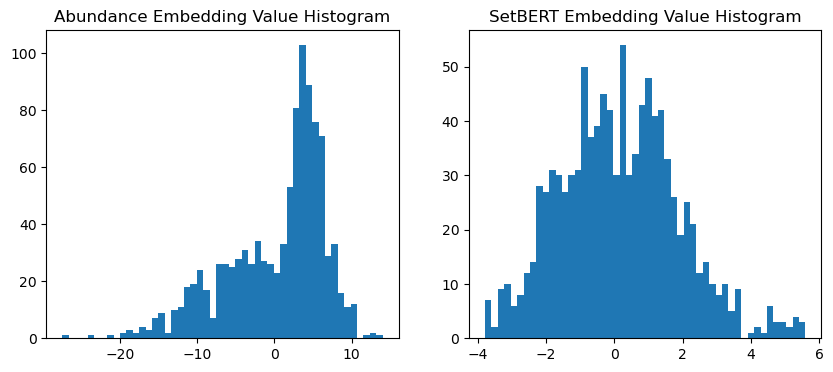

In [25]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Abundance Embedding Value Histogram")
plt.hist(abundance_encoder.predict(val_data[0][0][1]).flatten(), bins=50)

plt.subplot(1, 2, 2)
plt.title("SetBERT Embedding Value Histogram")
plt.hist(setbert_encoder.predict(val_data[0][0][0]).flatten(), bins=50)
plt.show()

1/1 [==============================] - 7s 7s/step


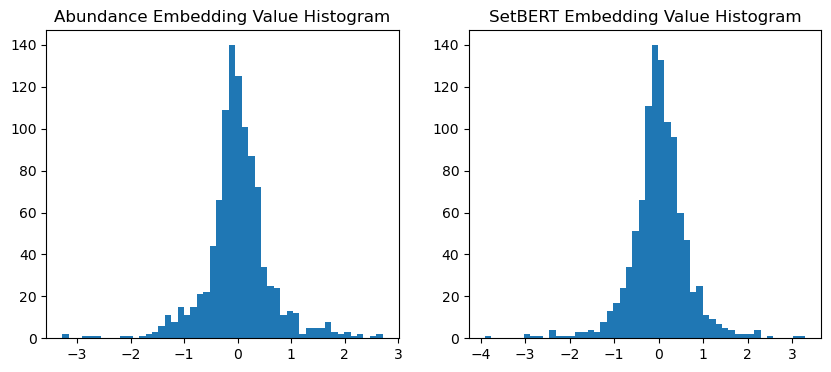

In [26]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Abundance Embedding Value Histogram")
plt.hist(abundance_encoder_extended.predict(val_data[0][0][1]).flatten(), bins=50)

plt.subplot(1, 2, 2)
plt.title("SetBERT Embedding Value Histogram")
plt.hist(setbert_encoder_extended.predict(val_data[0][0][0]).flatten(), bins=50)
plt.show()

In [ ]:
model.evaluate(val_data)

In [27]:
pred = np.reshape(model.predict(val_data), (-1, 16, 16))

16/16 [==============================] - 80s 5s/step


<AxesSubplot:title={'center':'Mean Predictions Across All Batches'}>

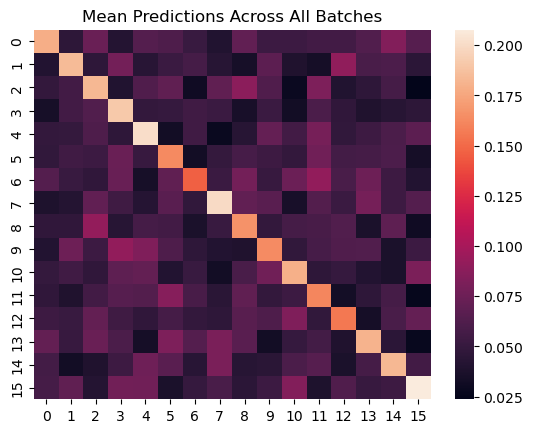

In [28]:
plt.title("Mean Predictions Across All Batches")
sns.heatmap(np.mean((tf.nn.softmax(pred, axis=2) + tf.nn.softmax(pred, axis=1)) / 2.0, axis=0))

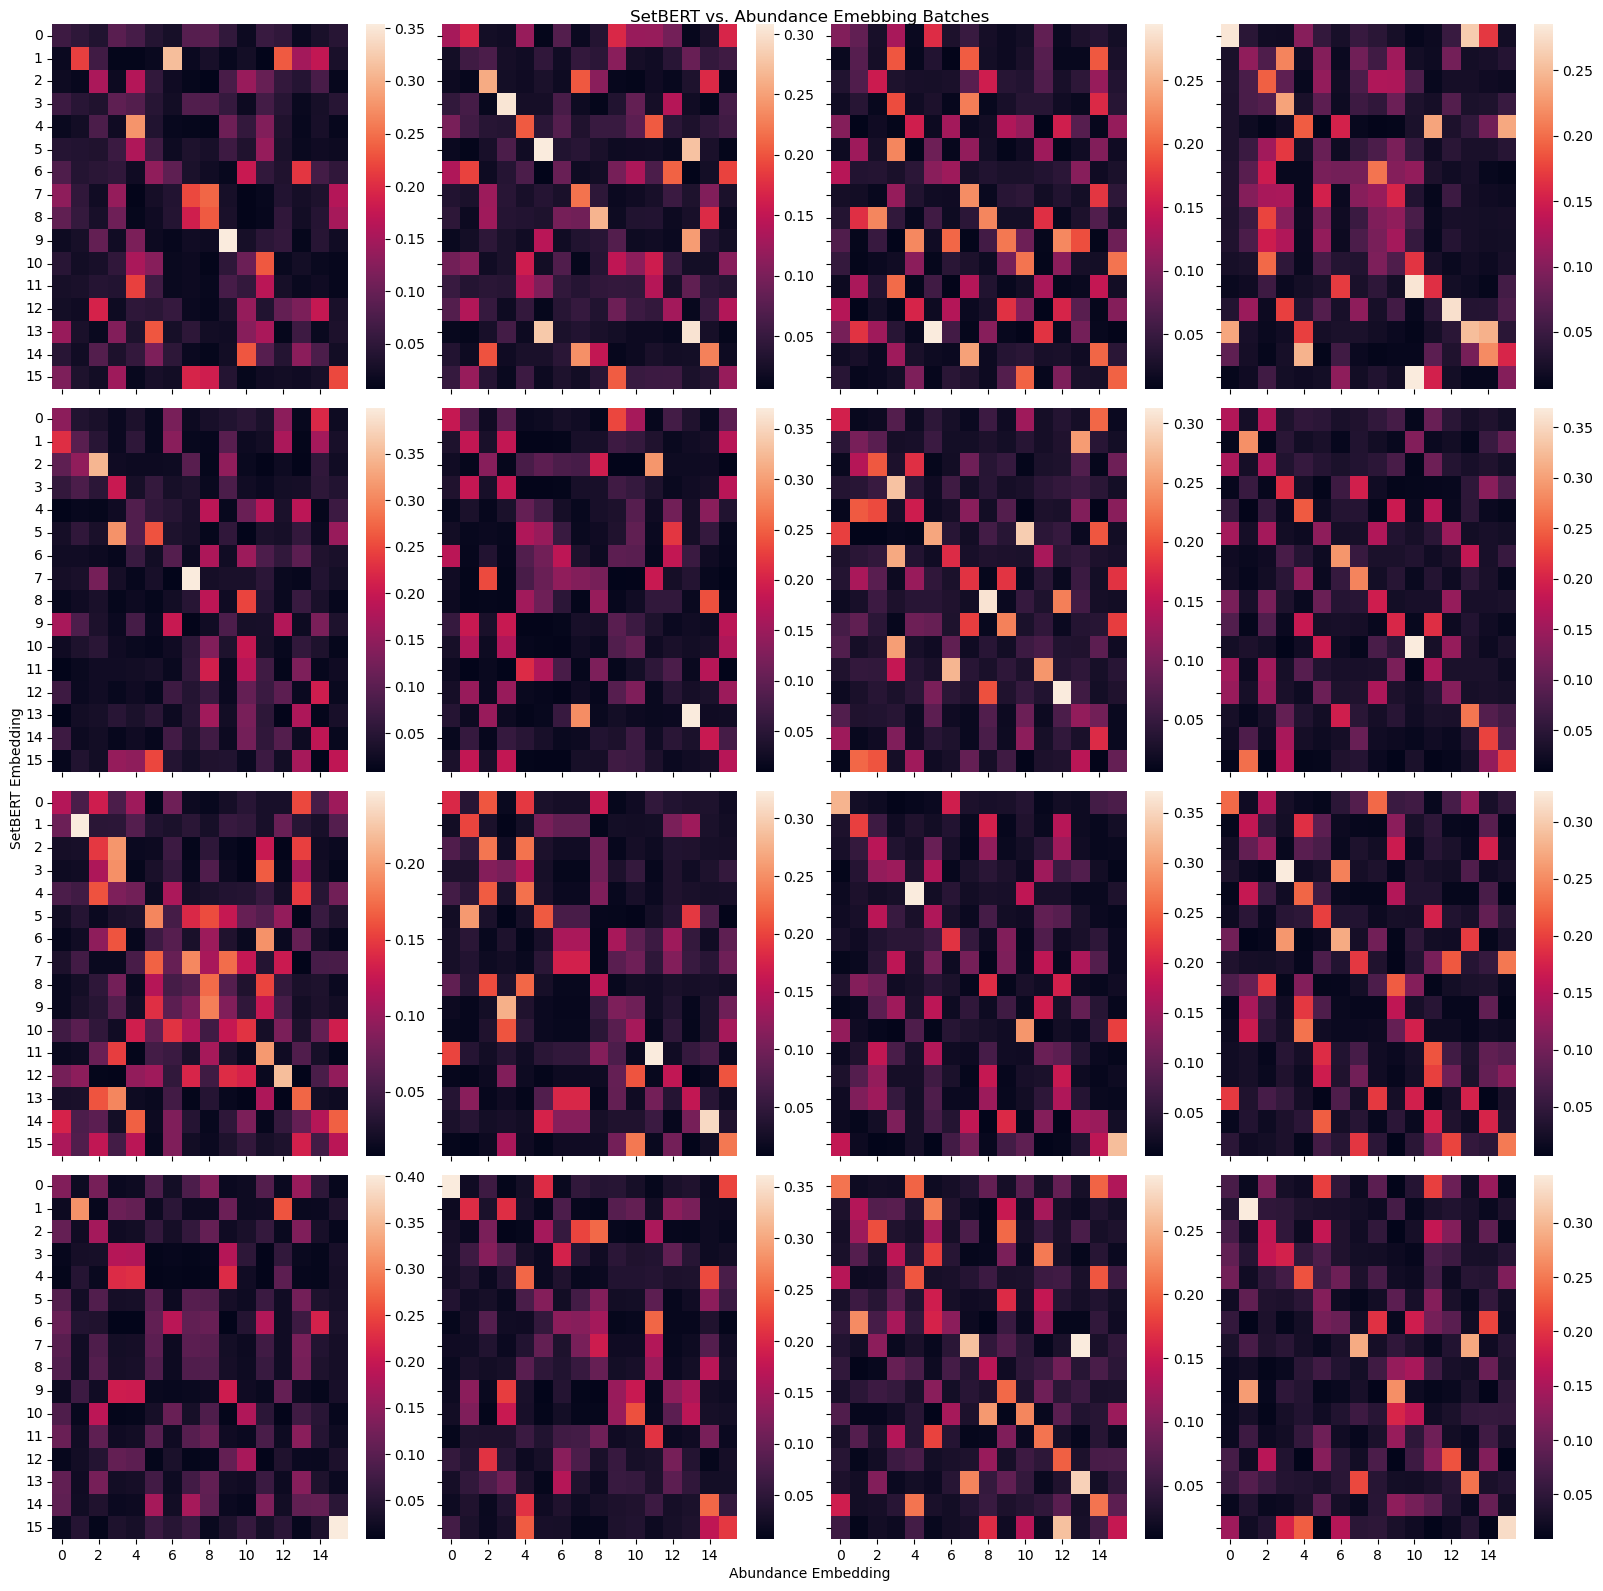

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)
axs = axs.flat
for i in range(len(pred)):
    plt.subplot(4, 4, i+1)
    sns.heatmap((tf.nn.softmax(pred[i]) + tf.nn.softmax(pred[i], axis=0)) / 2.0)
fig.tight_layout()
fig.text(0.5, 0.0, 'Abundance Embedding', ha='center')
fig.text(0.0, 0.5, 'SetBERT Embedding', va='center', rotation='vertical')
fig.suptitle("SetBERT vs. Abundance Emebbing Batches")
fig.tight_layout()
plt.show()

In [30]:
model.save("hopland-clip_pretrained_dual_loss_mse")

INFO:tensorflow:Assets written to: hopland-clip_pretrained_dual_loss_mse/assets


INFO:tensorflow:Assets written to: hopland-clip_pretrained_dual_loss_mse/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [31]:
# sequences, abundances = val_data[1]

In [32]:
rng = np.random.default_rng(0)
indices = rng.permutation(len(samples))[:10]
chosen_samples = [samples[i] for i in indices]
sample_names = [s.name for s in chosen_samples]
len(chosen_samples)

10

In [33]:
setbert_embeddings = []
abundance_embeddings = []
for s in tqdm(chosen_samples):
    (sequences, abundances), _ = SampleValuePairGenerator(
        [s],
        labels,
        sequence_length=150,
        kmer=3,
        subsample_size=1000,
        batch_size=10,
        batches_per_epoch=1,
        rng=rng)[0]
    setbert_embeddings.append(setbert_encoder_extended.predict(sequences))
    abundance_embeddings.append(abundance_encoder_extended(abundances[:1])[0])
setbert_embeddings = np.array(setbert_embeddings)
abundance_embeddings = np.array(abundance_embeddings)

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


In [34]:
setbert_embeddings.shape, abundance_embeddings.shape

((10, 10, 64), (10, 64))

In [35]:
setbert_embeddings.shape, abundance_embeddings.shape

((10, 10, 64), (10, 64))

In [36]:
abundance_embeddings[0]

array([ 0.23493323,  0.1609857 , -0.6371043 ,  0.555421  ,  0.12530869,
       -0.1054996 ,  0.08486551, -0.62816805,  2.4994953 , -0.8302    ,
        0.11913173,  0.34145445, -0.2160716 ,  0.20143044, -0.27557993,
       -0.51477873,  0.01660376,  0.6334925 , -1.7541322 , -0.22942866,
        0.20636275, -0.30893674, -0.01375998, -0.13954192,  0.3510427 ,
       -0.2630775 , -2.068623  ,  0.5200734 , -0.3392195 ,  0.8186459 ,
       -0.22274566, -0.27182475,  0.20742917, -0.4204604 , -0.85041183,
       -0.6937672 ,  0.80162376,  0.48822808, -0.07593389,  1.54543   ,
        0.09981705, -0.52047604,  0.48011866, -0.46471173,  0.6231598 ,
        0.66941273,  0.46409938,  0.02099369,  0.1749788 ,  0.39185083,
        0.3146797 ,  0.35489845, -0.45498502, -0.33089474, -0.52071893,
        0.11098276,  0.3710928 ,  0.00799361, -0.60783166, -0.20822108,
       -1.097124  ,  0.4239532 , -0.41855556, -0.12379114], dtype=float32)

In [37]:
np.mean(setbert_embeddings[0], axis=0)

array([-0.06540148,  0.2512551 , -0.97137433,  0.5055564 , -0.17780146,
       -0.4007961 , -0.24420282, -0.6628572 ,  2.2081501 , -0.9819628 ,
        0.36051166, -0.48031038,  0.56198823, -0.3234646 , -0.13274749,
       -0.4398176 ,  0.6918367 ,  0.6997177 , -0.84157693, -0.14327808,
        0.1886827 , -0.8330703 , -0.5413935 ,  0.33059096, -1.3482773 ,
       -0.537605  , -1.908783  ,  0.3623497 ,  0.05326917,  1.047288  ,
        0.08920138, -0.00885811,  0.28898025,  0.3684253 , -0.01592476,
       -0.48912495,  0.13620262,  0.30853024,  0.03322767, -0.7312403 ,
        0.90534896,  0.62253034,  1.4056015 , -0.6795624 ,  0.8325375 ,
        0.019814  , -0.74577373, -0.08052646, -0.08254673, -0.44356075,
        0.7488536 , -0.05542352, -0.23790932, -0.42408165, -0.8334842 ,
       -0.33316708,  0.56212705,  0.11964705, -0.2532403 , -0.5805985 ,
        0.26007873, -1.0174282 ,  0.25234   ,  0.40103012], dtype=float32)

In [38]:
a, b = abundance_embeddings[0], np.mean(setbert_embeddings[0], axis=0)
np.dot(a, b)/np.linalg.norm(a)/np.linalg.norm(b)

0.53749615

In [39]:
np.linalg.norm(a), np.linalg.norm(b)

(5.260441, 5.337238)

## MDS Projections

In [40]:
from scipy.spatial.distance import cdist

In [41]:
distance_measure = "cityblock"
metric = True

In [42]:
flat: np.ndarray = setbert_embeddings.reshape((-1, setbert_embeddings.shape[-1]))
sb_distance_matrix = cdist(flat, flat, distance_measure)
sb_distance_matrix.shape

(100, 100)

In [43]:
ab_distance_matrix = cdist(abundance_embeddings, abundance_embeddings, distance_measure)
ab_distance_matrix.shape

(10, 10)

In [44]:
sb_mds, _ = metrics.mds(sb_distance_matrix, ndim=2, metric=metric, seed=0)
sb_mds = sb_mds.reshape(len(chosen_samples), -1, 2)
sb_mds.shape

(10, 10, 2)

In [45]:
ab_mds, _ = metrics.mds(ab_distance_matrix, ndim=2, metric=metric, seed=0)
ab_mds.shape

(10, 2)

In [46]:
def mds_stress_analysis(dist_mat, dims, metric=True, seed=None, workers=1, **kwargs):
    """
    Compute the MDS stress value for the given possible range of components.
    """
    import multiprocessing
    if isinstance(dims, int):
        dims = range(1, dims+1)
    dims = list(dims)
    with multiprocessing.Pool(workers) as pool:
        stresses = pool.map(metrics.MdsStressAnalysisProcess(
            dist_mat, metric=metric, random_state=seed, **kwargs
        ), dims)
    print(stresses)
    return dims, stresses #(1 - np.cumsum(stresses) / np.sum(stresses))

In [47]:
sb_mds_stress = metrics.mds_stress_analysis(sb_distance_matrix, 64, metric=metric, seed=0, workers=1)
ab_mds_stress = metrics.mds_stress_analysis(ab_distance_matrix, 64, metric=metric, seed=0, workers=1)

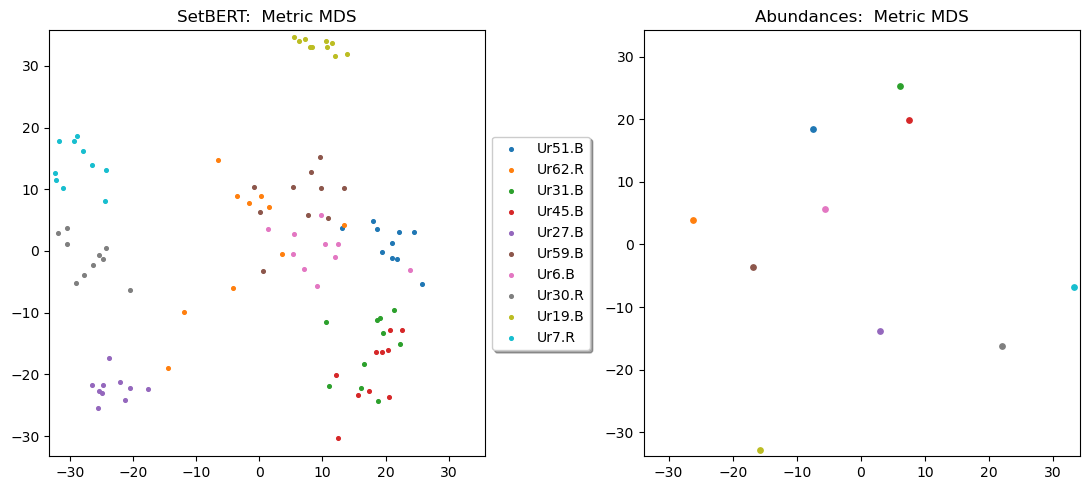

In [48]:
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title(f"SetBERT:  Metric MDS")
for name, points in zip(sample_names, sb_mds):
    plt.scatter(points[:,0], points[:,1], label=name, s=7)
plt.xlim((np.min(sb_mds) - 1, np.max(sb_mds) + 1))
plt.ylim((np.min(sb_mds) - 1, np.max(sb_mds) + 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)

plt.subplot(1, 2, 2)
plt.title(f"Abundances:  Metric MDS")
for name, point in zip(sample_names, ab_mds):
    plt.scatter([point[0]], [point[1]], label=name, s=15)

plt.xlim((np.min(ab_mds) - 1, np.max(ab_mds) + 1))
plt.ylim((np.min(ab_mds) - 1, np.max(ab_mds) + 1))
# plt.subplot(1, 2, 2)
# plt.title("MDS Stress Scree Plot")
# plt.plot(*mds_stress)
# plt.xlabel("Number of Components")
# plt.ylabel("1 - Cumulative Stress")
# plt.tight_layout()
# plt.savefig("mds_scree_plot.png")
plt.tight_layout()
plt.show()

In [49]:
flat = np.reshape(setbert_embeddings, (-1, 64))
all_embeddings = np.concatenate((flat, abundance_embeddings), axis=0)
all_embeddings.shape

(110, 64)

In [50]:
abundance_embeddings.shape

(10, 64)

In [51]:
distance_matrix = cdist(all_embeddings, all_embeddings, distance_measure)
distance_matrix.shape

(110, 110)

In [52]:
mds, _ = metrics.mds(distance_matrix, ndim=2, metric=metric, seed=0)
mds.shape

(110, 2)

In [53]:
sb_mds = mds[:100].reshape((10, 10, 2))
ab_mds = mds[100:]

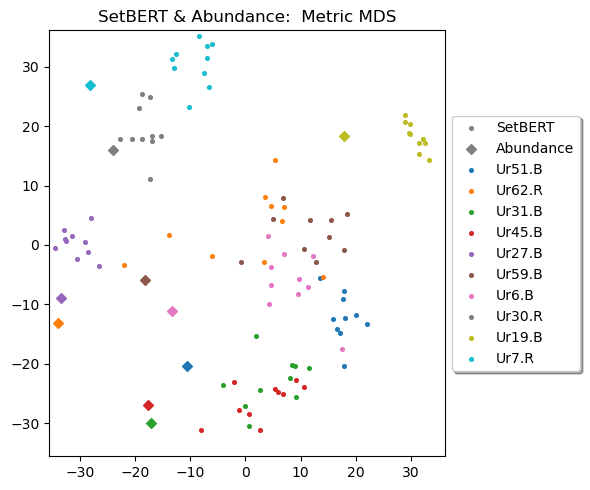

In [54]:
plt.figure(figsize=(6, 5))
plt.title(f"SetBERT & Abundance:  Metric MDS")
plt.scatter([], [], color="gray", label="SetBERT", s=7)
plt.scatter([], [], color="gray", label="Abundance", s=25, marker='D')
for name, points in zip(sample_names, sb_mds):
    plt.scatter(points[:,0], points[:,1], label=name, marker='o', s=7)
for name, point in zip(sample_names, ab_mds):
    plt.scatter([point[0]], [point[1]], s=25, marker='D')
plt.xlim((np.min((np.min(sb_mds), np.min(ab_mds))) - 1, np.max((np.max(sb_mds), np.max(ab_mds))) + 1))
plt.ylim((np.min((np.min(sb_mds), np.min(ab_mds))) - 1, np.max((np.max(sb_mds), np.max(ab_mds))) + 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.tight_layout()
plt.show()

In [57]:
NPCs = TSNE(n_components=2, metric="precomputed").fit_transform(distance_matrix)
NPCs.shape

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(110, 2)

In [58]:
sb_npcs = NPCs[:100].reshape((10, 10, 2))
ab_npcs = NPCs[100:]

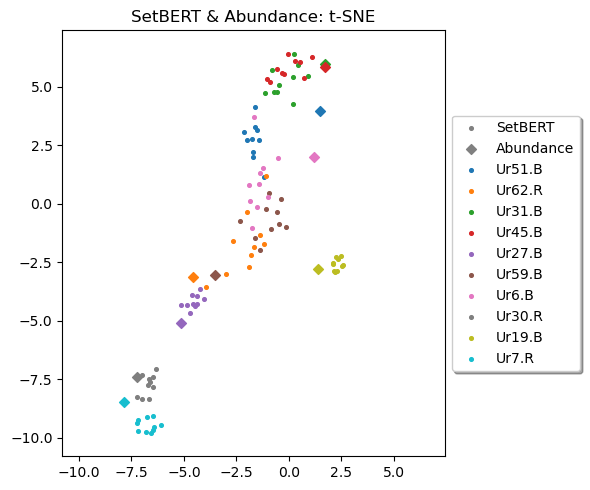

In [59]:
plt.figure(figsize=(6, 5))
plt.title(f"SetBERT & Abundance: t-SNE")
plt.scatter([], [], color="gray", label="SetBERT", s=7)
plt.scatter([], [], color="gray", label="Abundance", s=25, marker='D')
for name, points in zip(sample_names, sb_npcs):
    plt.scatter(points[:,0], points[:,1], label=name, marker='o', s=7)
for name, point in zip(sample_names, ab_npcs):
    plt.scatter([point[0]], [point[1]], s=25, marker='D')
plt.xlim((np.min(NPCs) - 1, np.max(NPCs) + 1))
plt.ylim((np.min(NPCs) - 1, np.max(NPCs) + 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.tight_layout()
plt.show()

In [60]:
sorted_samples = [s for s in sorted(samples, key=lambda s: s.name)]
sorted_samples = sorted_samples[::2] + sorted_samples[1::2]
sample_names = [s.name for s in sorted_samples]
len(sample_names)

['Ur1.B',
 'Ur10.B',
 'Ur11.B',
 'Ur12.B',
 'Ur13.B',
 'Ur14.B',
 'Ur15.B',
 'Ur16.B',
 'Ur17.B',
 'Ur18.B',
 'Ur19.B',
 'Ur2.B',
 'Ur20.B',
 'Ur21.B',
 'Ur22.B',
 'Ur23.B',
 'Ur24.B',
 'Ur25.B',
 'Ur26.B',
 'Ur27.B',
 'Ur28.B',
 'Ur29.B',
 'Ur3.B',
 'Ur30.B',
 'Ur31.B',
 'Ur32.B',
 'Ur33.B',
 'Ur34.B',
 'Ur35.B',
 'Ur36.B',
 'Ur37.B',
 'Ur38.B',
 'Ur39.B',
 'Ur4.B',
 'Ur40.B',
 'Ur41.B',
 'Ur42.B',
 'Ur43.B',
 'Ur44.B',
 'Ur45.B',
 'Ur46.B',
 'Ur47.B',
 'Ur48.B',
 'Ur49.B',
 'Ur5.B',
 'Ur50.B',
 'Ur51.B',
 'Ur52.B',
 'Ur53.B',
 'Ur54.B',
 'Ur55.B',
 'Ur56.B',
 'Ur57.B',
 'Ur58.B',
 'Ur59.B',
 'Ur6.B',
 'Ur60.B',
 'Ur61.B',
 'Ur62.B',
 'Ur63.B',
 'Ur64.B',
 'Ur7.B',
 'Ur8.B',
 'Ur9.B',
 'Ur1.R',
 'Ur10.R',
 'Ur11.R',
 'Ur12.R',
 'Ur13.R',
 'Ur14.R',
 'Ur15.R',
 'Ur16.R',
 'Ur17.R',
 'Ur18.R',
 'Ur19.R',
 'Ur2.R',
 'Ur20.R',
 'Ur21.R',
 'Ur22.R',
 'Ur23.R',
 'Ur24.R',
 'Ur25.R',
 'Ur26.R',
 'Ur27.R',
 'Ur28.R',
 'Ur29.R',
 'Ur3.R',
 'Ur30.R',
 'Ur31.R',
 'Ur32.R',
 'Ur33.R',
 'Ur34.R',


Ensure the Rs and Bs are partitioned.

In [61]:
for name in sample_names[:len(sample_names) // 2]:
    assert name.endswith(".B")
for name in sample_names[len(sample_names) // 2:]:
    assert name.endswith(".R")

Draw random subsamples using the SequenceSampler.

In [62]:
rng = np.random.default_rng()
sb_subsamples_list = []
for i, s in enumerate(sorted_samples):
    print(f"\r{i+1}/{len(sorted_samples)}", end="")
    sequences, _ = SequenceGenerator(
        [s],
        sequence_length=150,
        kmer=3,
        subsample_size=1000,
        batch_size=10,
        batches_per_epoch=1,
        rng=rng)[0]
    sb_subsamples_list.append(setbert_encoder_extended.predict(sequences, verbose=0))
sb_subsamples = np.array(sb_subsamples_list)
sb_subsamples.shape

128/128

(128, 10, 64)

In [63]:
ab_subsamples = []
for s in sorted_samples:
    embedding = abundance_encoder_extended.predict(np.array([labels[s.name]]), verbose=0)
    ab_subsamples.append(embedding.squeeze())
ab_subsamples = np.array(ab_subsamples)
ab_subsamples.shape

(128, 64)

## MDS Projections

In [64]:
distance_measure = "cityblock"
metric = True

In [65]:
flat: np.ndarray = sb_subsamples.reshape((-1, sb_subsamples.shape[-1]))
sb_distance_matrix = cdist(flat, flat, distance_measure)
sb_distance_matrix.shape

(1280, 1280)

In [66]:
sb_mds, _ = metrics.mds(sb_distance_matrix, ndim=2, metric=metric)
# mds = mds.reshape(len(samples), -1, 2)
sb_mds.shape

(1280, 2)

In [67]:
ab_distance_matrix = cdist(ab_subsamples, ab_subsamples)
ab_distance_matrix.shape

(128, 128)

In [68]:
ab_mds, _ = metrics.mds(ab_distance_matrix, ndim=2, metric=metric)
ab_mds.shape

(128, 2)

In [69]:
# samples_to_remove = [10, 116]
# for i in samples_to_remove:
#     print(sample_names[i])

In [70]:
# mod_sb_mds = sb_mds
# for i in sorted(samples_to_remove, reverse=True):
#     mod_sb_mds = np.concatenate((mod_sb_mds[:i*10], mod_sb_mds[(i+1)*10:]))
# mod_sb_mds.shape

In [71]:
# np.where(mod_sb_mds[:,1] < -6)

In [72]:
# mds_stress = metrics.mds_stress_analysis(distance_matrix, 64, metric=metric, seed=SEED, workers=1)

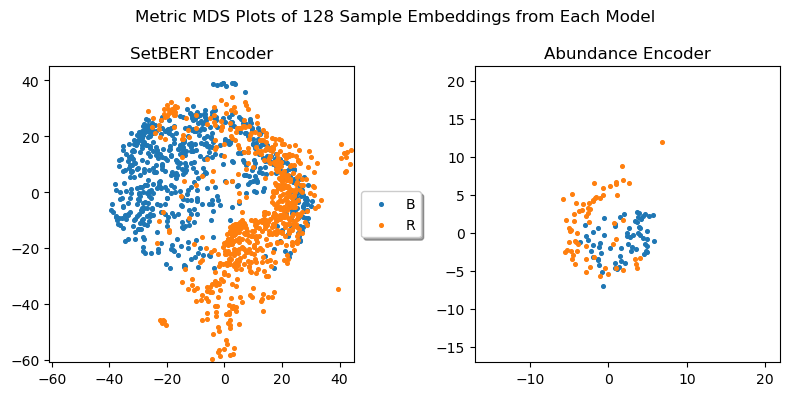

In [73]:
plt.figure(figsize=(8, 4))
plt.suptitle(f"Metric MDS Plots of {len(samples)} Sample Embeddings from Each Model")

plt.subplot(1, 2, 1)
plt.title(f"SetBERT Encoder")
x, y = sb_mds.T
plt.scatter(x[:len(sb_mds)//2], y[:len(sb_mds)//2], label="B", s=7)
plt.scatter(x[len(sb_mds)//2:], y[len(sb_mds)//2:], label="R", s=7)
plt.xlim((np.min(sb_mds) - 1, np.max(sb_mds) + 1))
plt.ylim((np.min(sb_mds) - 1, np.max(sb_mds) + 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)

plt.subplot(1, 2, 2)
plt.title(f"Abundance Encoder")
x, y = ab_mds.T
plt.scatter(x[:len(ab_mds)//2], y[:len(ab_mds)//2], label="B", s=7)
plt.scatter(x[len(ab_mds)//2:], y[len(ab_mds)//2:], label="R", s=7)
plt.xlim((np.min(ab_mds) - 10, np.max(ab_mds) + 10))
plt.ylim((np.min(ab_mds) - 10, np.max(ab_mds) + 10))
plt.tight_layout()
plt.show()

In [74]:
flat = np.reshape(sb_subsamples, (-1, 64))
flat = np.concatenate((flat, ab_subsamples), axis=0)
flat.shape

(1408, 64)

In [75]:
distance_matrix = cdist(flat, flat, distance_measure)
distance_matrix.shape

(1408, 1408)

In [76]:
mds, _ = metrics.mds(distance_matrix, ndim=2, metric=metric)
mds.shape

(1408, 2)

In [77]:
sb_mds, ab_mds = mds[:1280], mds[1280:]
sb_mds.shape, ab_mds.shape

((1280, 2), (128, 2))

In [78]:
sb_b = sb_mds[:len(sb_mds)//2]
sb_r = sb_mds[len(sb_mds)//2:]
sb_b.shape, sb_r.shape

((640, 2), (640, 2))

In [79]:
ab_b = ab_mds[:len(ab_mds)//2]
ab_r = ab_mds[len(ab_mds)//2:]
ab_b.shape, ab_r.shape

((64, 2), (64, 2))

In [80]:
import matplotlib as mpl
cmap = mpl.colormaps["tab10"]

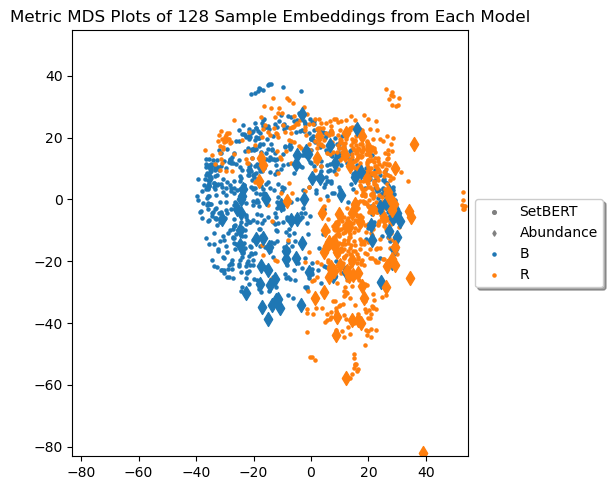

In [81]:
plt.figure(figsize=(6, 5))
plt.title(f"Metric MDS Plots of {len(samples)} Sample Embeddings from Each Model")

plt.scatter([], [], label="SetBERT", s=7, color='gray')
plt.scatter([], [], label="Abundance", s=7, marker='d', color='gray')

x, y = sb_mds.T
t = plt.scatter(x[:len(sb_mds)//2], y[:len(sb_mds)//2], label="B", s=5, color=cmap.colors[0])
plt.scatter(x[len(sb_mds)//2:], y[len(sb_mds)//2:], label="R", s=5, color=cmap.colors[1])

x, y = ab_mds.T
plt.scatter(x[:len(ab_mds)//2], y[:len(ab_mds)//2], s=50, marker='d', color=cmap.colors[0])
plt.scatter(x[len(ab_mds)//2:], y[len(ab_mds)//2:], s=50, marker='d', color=cmap.colors[1])

plt.xlim((np.min(mds) - 1, np.max(mds) + 1))
plt.ylim((np.min(mds) - 1, np.max(mds) + 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.tight_layout()
plt.show()

## tSNE

In [82]:
from sklearn.manifold import TSNE

In [83]:
distance_matrix.shape

(1408, 1408)

In [84]:
%%time

NPCs = TSNE(n_components=2, metric="precomputed").fit_transform(distance_matrix)

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 2min 20s, sys: 3.79 s, total: 2min 24s
Wall time: 2.37 s


In [85]:
NPCs.shape

(1408, 2)

In [86]:
sb_npc, ab_npc = NPCs[:1280], NPCs[1280:]
sb_npc.shape, ab_npc.shape

((1280, 2), (128, 2))

In [87]:
sb_b = sb_npc[:len(sb_npc)//2]
sb_r = sb_npc[len(sb_npc)//2:]
sb_b.shape, sb_r.shape

((640, 2), (640, 2))

In [88]:
ab_b = ab_npc[:len(ab_npc)//2]
ab_r = ab_npc[len(ab_npc)//2:]
ab_b.shape, ab_r.shape

((64, 2), (64, 2))

In [89]:
cmap.colors[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

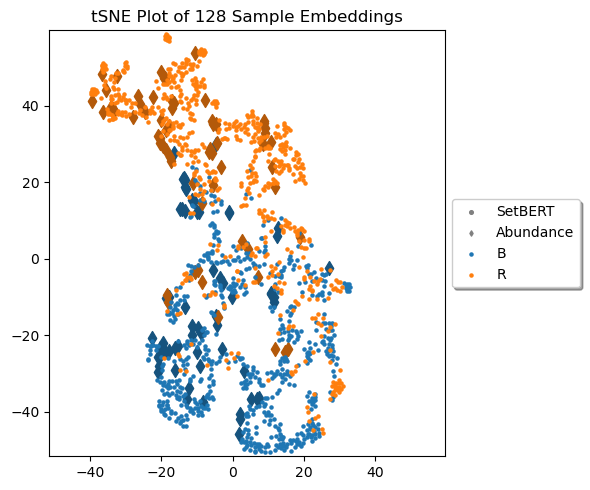

In [90]:
plt.figure(figsize=(6, 5))
plt.title(f"tSNE Plot of {len(samples)} Sample Embeddings")

plt.scatter([], [], label="SetBERT", s=7, color='gray')
plt.scatter([], [], label="Abundance", s=7, marker='d', color='gray')

x, y = ab_npc.T
plt.scatter(x[:len(ab_npc)//2], y[:len(ab_npc)//2], s=50, marker='d', color=np.array(cmap.colors[0])*0.7)
plt.scatter(x[len(ab_npc)//2:], y[len(ab_npc)//2:], s=50, marker='d', color=np.array(cmap.colors[1])*0.7)

x, y = sb_npc.T
t = plt.scatter(x[:len(sb_npc)//2], y[:len(sb_npc)//2], label="B", s=5, color=cmap.colors[0])
plt.scatter(x[len(sb_npc)//2:], y[len(sb_npc)//2:], label="R", s=5, color=cmap.colors[1])

plt.xlim((np.min(NPCs) - 1, np.max(NPCs) + 1))
plt.ylim((np.min(NPCs) - 1, np.max(NPCs) + 1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.tight_layout()
plt.show()